<a href="https://colab.research.google.com/github/Ekliipce/Machine-Learning-for-Biomedical/blob/main/federated_learning/Federated_Learning_etudiants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [6]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [17]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset
from collections import defaultdict


from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [8]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
  n = n_samples_per_node
  subset = [Subset(dataset, list(range(i*n, (i+1)*n))) for i in range(nb_nodes)]
  loader = [DataLoader(subset[i], batch_size=batch_size, shuffle=shuffle)
            for i in range(nb_nodes)]

  return loader

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [36]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    targets = dataset.targets
    indices = np.arange(len(targets))

    node_indices = []
    for i in range(nb_nodes):
        # Select indices where target is i modulo nb_nodes
        node_idx = indices[targets % nb_nodes == i][:n_samples_per_node]
        node_indices.append(node_idx)

    subsets = [Subset(dataset, idx) for idx in node_indices]
    loaders = [DataLoader(sub, batch_size=batch_size, shuffle=shuffle) for sub in subsets]

    return loaders

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [11]:
IID = 'iid'
NON_IID = 'non_iid'

def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    mnist_train = torchvision.datasets.MNIST(root="./", train=True, download=True,
                                             transform=transform)
    mnist_test = torchvision.datasets.MNIST(root="./", train=False, download=True,
                                             transform=transform)

    if (type == "iid"):
      train = iid_split(mnist_train, n_clients, n_samples_train, batch_size, shuffle)
      test = iid_split(mnist_test, n_clients, n_samples_test, batch_size, shuffle)
    else :
      train = non_iid_split(mnist_train, n_clients, n_samples_train, batch_size, shuffle)
      test = non_iid_split(mnist_test, n_clients, n_samples_test, batch_size, shuffle)

    return train, test

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [12]:
mnist_iid_train, mnist_iid_test = get_MNIST(n_samples_train=200, n_samples_test=100,
                                            n_clients=3, batch_size=25,)

100%|██████████| 9912422/9912422 [00:00<00:00, 102306970.40it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 54078434.74it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28244959.84it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13735060.40it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [13]:
for idx, loader in enumerate(mnist_iid_train):
    total_samples = 0
    for data in loader:
        batch_size = len(data[0])
        total_samples += batch_size
    print(f"Client {idx + 1}, Batch size: {batch_size}")
    print(f"Client {idx + 1}, Total samples: {total_samples}")
    print(f"Client {idx + 1}, Number of batches: {len(loader)}\n")

Client 1, Batch size: 25
Client 1, Total samples: 200
Client 1, Number of batches: 8

Client 2, Batch size: 25
Client 2, Total samples: 200
Client 2, Number of batches: 8

Client 3, Batch size: 25
Client 3, Total samples: 200
Client 3, Number of batches: 8



5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [14]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    #plt.figure(figsize=(1* n_rows, 1*n_rows))
    plt.figure(figsize=(5, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

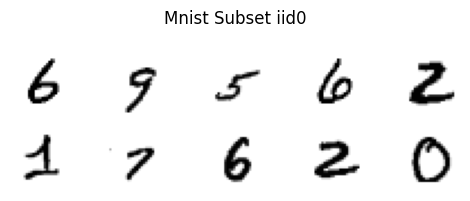

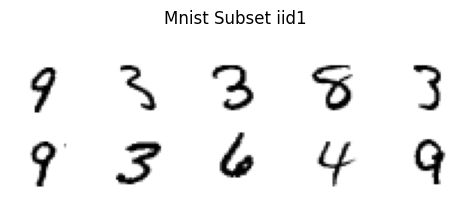

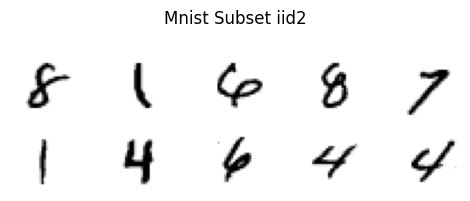

In [40]:
for i in range(3):
  plot_samples(next(iter(mnist_iid_train[i])), 0, title="Mnist Subset iid" + str(i),  n_examples=10)

6) Plot samples this time for non_iid data for 3 clients.

In [37]:
mnist_noniid_train, mnist_noniid_test = get_MNIST(type=NON_IID,
                                                  n_samples_train=200,
                                                  n_samples_test=100,
                                                  n_clients=3,
                                                  batch_size=25,)

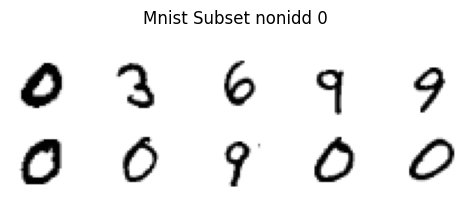

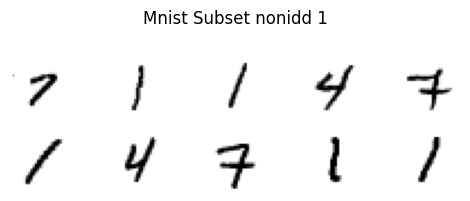

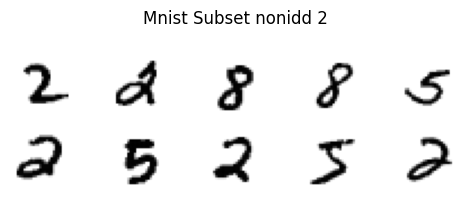

In [41]:
for i in range(3):
  plot_samples(next(iter(mnist_noniid_train[i])), 0, title="Mnist Subset nonidd " + str(i),  n_examples=10)

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [42]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [43]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    q_difference_sum = 0
    for v1, v2 in zip(model_1.state_dict().values(), model_2.state_dict().values()):
      q_difference_sum += torch.pow(v1-v2, 2).sum()

    return q_difference_sum


In [44]:
model_1 = CNN()
model_2 = CNN()

print(difference_models_norm_2(model_0, model_1))
print(difference_models_norm_2(model_0, model_2))
print(difference_models_norm_2(model_1, model_2))

tensor(388.7535)
tensor(389.6163)
tensor(387.8614)


**Federated Optimization in Heterogeneous Networks**:<br><br>
$F_k(w) + \frac{\mu}{2} \cdot ||w_1, w_2||^2$ <br><br>

In Federated Learning, especially in heterogeneous networks, data distribution across clients (nodes) is usually non-iid, meaning that the data available at each client can be highly skewed or different. Heterogeneous networks also imply variations in computation and communication resources among the nodes.

- Local Optimization: Each client kk optimizes its local objectiveusing its data. The local objective combines the empirical risk and the regularization term, striking a balance between fitting the local data and maintaining model simplicity.

- Global Aggregation: After local optimization, the server aggregates the locally-computed models to form a global model. This global model is then sent back to the clients for the next round of federated optimization.

- Dealing with Heterogeneity: The regularization term helps in mitigating the challenges posed by the data and resource heterogeneity among the clients. It provides a form of structure to the optimization problem, helping the global model to generalize well across diverse local datasets.

Here is the function to perform one epoch of training data.

In [45]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss += mu/2*difference_models_norm_2(model, model_0)
        total_loss += loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [46]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    ### Copy model to a new variable ###
    model_cpy = deepcopy(model)

    local_loss = 0
    for epoch in range(epochs):
        local_loss = train_step(model, model_cpy, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [47]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [48]:
def average_models(model, clients_models_hist:list , weights:list):
    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

FedProx follows this Iterative Learning:
1. Central server choose a statiscal server to be trained
2. Central server transmit the initial model to several nodes
3. Nodes train the model locally with thier own Data
4. Central server pools model result and generate one global mode without accessing any data

The step 2, 3 and 4 are repeated n_iterations

In [49]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model = deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss = local_learning(local_model, mu, local_optimizer,
                                        training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [50]:
global_model = CNN()
model, loss_hist, acc_hist = FedProx(global_model, mnist_iid_train,
                                     20, mnist_iid_test)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3048810164133706 Server Test Accuracy: 4.333333333333333
====> i: 1 Loss: 1.8980962038040161 Server Test Accuracy: 44.666666666666664
====> i: 2 Loss: 0.24218680957953131 Server Test Accuracy: 82.33333333333333
====> i: 3 Loss: 0.14360345651706058 Server Test Accuracy: 87.66666666666666
====> i: 4 Loss: 0.07811520621180534 Server Test Accuracy: 90.99999999999999
====> i: 5 Loss: 0.047163809339205415 Server Test Accuracy: 92.33333333333333
====> i: 6 Loss: 0.026649676573773224 Server Test Accuracy: 92.0
====> i: 7 Loss: 0.009646756419291098 Server Test Accuracy: 93.0
====> i: 8 Loss: 0.008860148877526322 Server Test Accuracy: 91.0
====> i: 9 Loss: 0.00868723557020227 Server Test Accuracy: 93.66666666666666
====> i: 10 Loss: 0.01092702136763061 Server Test Accuracy: 92.33333333333333
====> i: 11 Loss: 0.0004332881015898238 Server Test Accuracy: 92.0
====> i: 12 Loss: 0.0003081913509580166 Se

2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

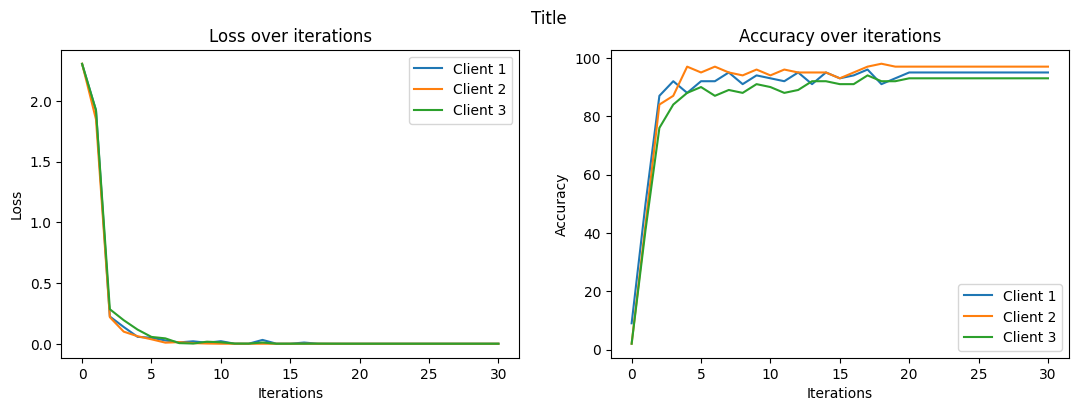

In [51]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
  iterations = range(1, len(loss_hist[0]) + 1)

  fig, axs = plt.subplots(1, 2, figsize=(13, 4))
  fig.suptitle(title)

  for i in range(len(loss_hist[-1])):
      loss = [loss_hist[k][i] for k in range(len(loss_hist))]
      axs[0].plot(loss, label=f'Client {i+1}')
  axs[0].set_xlabel('Iterations')
  axs[0].set_ylabel('Loss')
  axs[0].legend()
  axs[0].set_title('Loss over iterations')

  for i in range(len(acc_hist[-1])):
      acc = [acc_hist[k][i] for k in range(len(loss_hist))]
      axs[1].plot(acc, label=f'Client {i+1}')
  axs[1].set_xlabel('Iterations')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()
  axs[1].set_title('Accuracy over iterations')

  plt.show()

plot_acc_loss("Train FedAvg on iid", loss_hist, acc_hist)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [53]:
n_iter = 20
epochs = 5
lr = 0.01
mu = 0.3

model_prox = CNN()

final_model_prox, loss_hist_prox, acc_hist_prox = FedProx(model_prox, mnist_iid_train,
                                                          n_iter,  mnist_iid_test,
                                                          mu=mu,  epochs=epochs, lr=lr)


Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.303496996561686 Server Test Accuracy: 8.0
====> i: 1 Loss: 2.132933775583903 Server Test Accuracy: 52.33333333333333
====> i: 2 Loss: 0.21295709162950516 Server Test Accuracy: 86.0
====> i: 3 Loss: 0.12818276012937227 Server Test Accuracy: 89.66666666666666
====> i: 4 Loss: 0.06789356345931688 Server Test Accuracy: 92.0
====> i: 5 Loss: 0.04291564847032229 Server Test Accuracy: 93.33333333333333
====> i: 6 Loss: 0.03968344333892067 Server Test Accuracy: 92.33333333333333
====> i: 7 Loss: 0.05420664666841427 Server Test Accuracy: 89.66666666666666
====> i: 8 Loss: 0.020215545160075028 Server Test Accuracy: 92.33333333333333
====> i: 9 Loss: 0.05433770574745722 Server Test Accuracy: 90.66666666666666
====> i: 10 Loss: 0.008881462184945121 Server Test Accuracy: 90.0
====> i: 11 Loss: 0.0055750585937251644 Server Test Accuracy: 93.0
====> i: 12 Loss: 0.002133730298131316 Server Test Accuracy: 

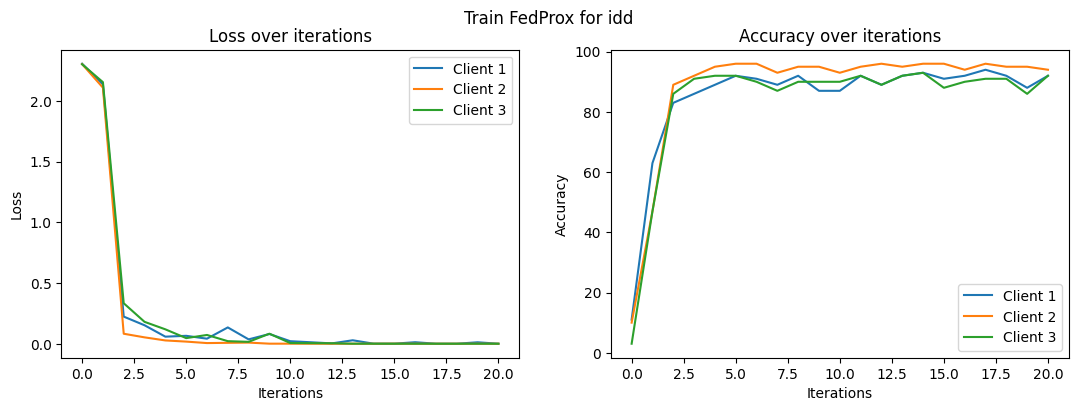

In [54]:
plot_acc_loss("Train FedProx for idd", loss_hist_prox, acc_hist_prox)

4) What do you observe ?

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3043597539265948 Server Test Accuracy: 8.333333333333334
====> i: 1 Loss: 2.277925650278727 Server Test Accuracy: 17.333333333333332
====> i: 2 Loss: 1.4786229133605957 Server Test Accuracy: 47.666666666666664
====> i: 3 Loss: 0.7513743738333383 Server Test Accuracy: 68.66666666666666
====> i: 4 Loss: 0.6016946832338969 Server Test Accuracy: 75.66666666666666
====> i: 5 Loss: 0.26698342462380725 Server Test Accuracy: 84.66666666666666
====> i: 6 Loss: 0.26202842593193054 Server Test Accuracy: 85.0
====> i: 7 Loss: 0.2702583372592926 Server Test Accuracy: 81.0
====> i: 8 Loss: 0.18411000569661456 Server Test Accuracy: 87.33333333333333
====> i: 9 Loss: 0.3540774012605349 Server Test Accuracy: 82.0
====> i: 10 Loss: 0.9533499479293822 Server Test Accuracy: 75.33333333333333
====> i: 11 Loss: 0.36291468640168506 Server Test Accuracy: 85.0
====> i: 12 Loss: 0.45008023828268046 Server Test Accu

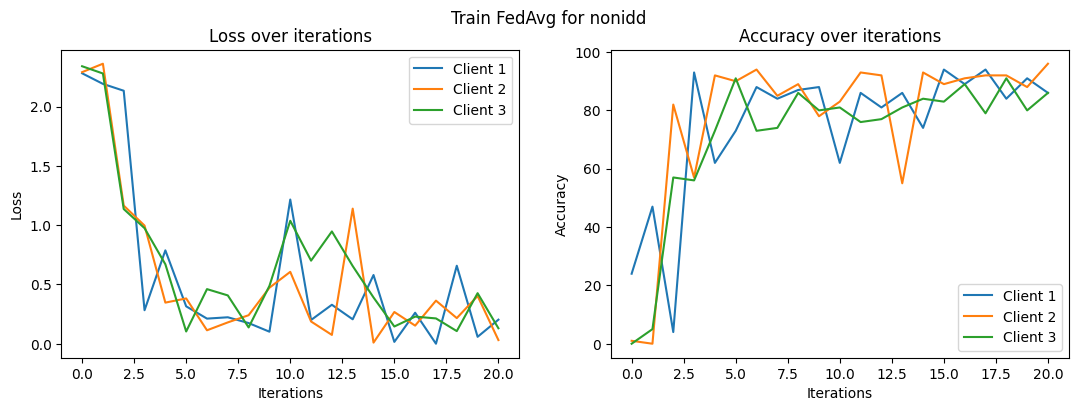

In [57]:
model = CNN()
final_model_avg, loss_hist_avg, acc_hist_avg = FedProx(model, mnist_noniid_train,
                                                       n_iter, mnist_noniid_test, mu=0,
                                                       epochs=5, lr=0.01)
plot_acc_loss('Train FedAvg for nonidd', loss_hist_avg, acc_hist_avg)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.305292685826619 Server Test Accuracy: 8.0
====> i: 1 Loss: 2.247187217076619 Server Test Accuracy: 31.0
====> i: 2 Loss: 1.583820899327596 Server Test Accuracy: 49.0
====> i: 3 Loss: 0.9532552560170491 Server Test Accuracy: 75.66666666666666
====> i: 4 Loss: 0.8699171940485636 Server Test Accuracy: 64.66666666666666
====> i: 5 Loss: 0.6204797625541687 Server Test Accuracy: 75.0
====> i: 6 Loss: 0.6520957847436268 Server Test Accuracy: 71.66666666666666
====> i: 7 Loss: 0.5578110814094543 Server Test Accuracy: 73.0
====> i: 8 Loss: 0.5066431959470112 Server Test Accuracy: 74.0
====> i: 9 Loss: 0.41227279106775916 Server Test Accuracy: 77.66666666666666
====> i: 10 Loss: 0.6117943127950032 Server Test Accuracy: 69.33333333333333
====> i: 11 Loss: 0.5163519779841105 Server Test Accuracy: 72.33333333333333
====> i: 12 Loss: 0.4599656562010447 Server Test Accuracy: 76.66666666666666
====> i: 13

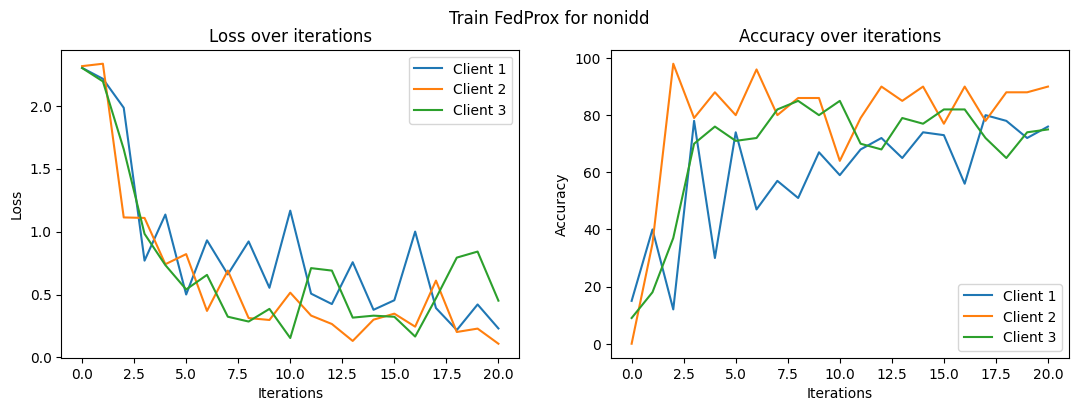

In [59]:
model = CNN()
final_model_avg, loss_hist_avg, acc_hist_avg = FedProx(model, mnist_noniid_train,
                                                       n_iter, mnist_noniid_test, mu=0.3,
                                                       epochs=5, lr=0.01)
plot_acc_loss('Train FedProx for nonidd', loss_hist_avg, acc_hist_avg)

2) What do you observe ?

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [60]:
! pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=c1ddc59a52b1173a44b48845d82614d36916ccc9fd496561c5ec37215b75248c
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Import medmnist

In [61]:
import medmnist

You can list all available datasets with this command

In [62]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [63]:
from medmnist import BloodMNIST

In [64]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [65]:
pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [66]:
train_dataset = BloodMNIST(root='./', split='train', download=True, transform=pipeline)
test_dataset = BloodMNIST(root='./', split='test', download=True, transform=pipeline)

100%|██████████| 35461855/35461855 [00:59<00:00, 597102.45it/s]


Using downloaded and verified file: ./bloodmnist.npz


In [67]:
train_dataset.info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

In [98]:
dir(train_dataset)
train_dataset.labels

array([[7],
       [3],
       [6],
       ...,
       [1],
       [6],
       [4]], dtype=uint8)

4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

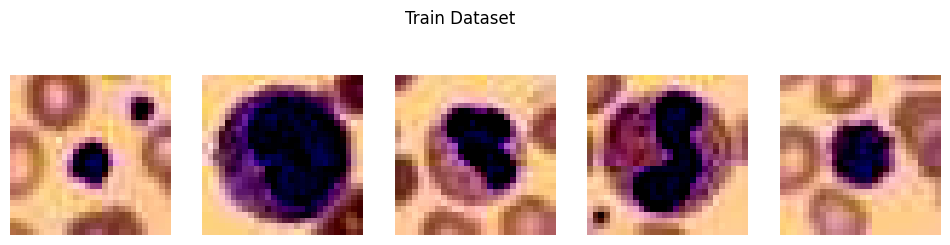

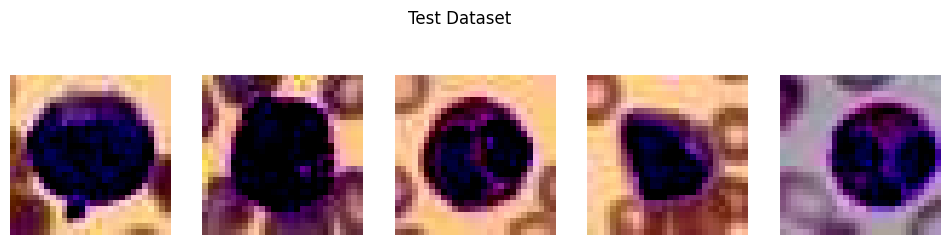

In [68]:
def plot_dataset(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        index = np.random.randint(len(dataset))
        img, label = dataset[i]
        img = img.permute(1, 2, 0)
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle(title)
    plt.show()

plot_dataset(train_dataset, 'Train Dataset')
plot_dataset(test_dataset, 'Test Dataset')

5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [69]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [99]:
def non_iid_split2(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    targets = dataset.labels.flatten()
    indices = np.arange(len(targets))

    node_indices = []
    for i in range(nb_nodes):
        # Select indices where target is i modulo nb_nodes
        node_idx = indices[targets % nb_nodes == i][:n_samples_per_node]
        node_indices.append(node_idx)

    subsets = [Subset(dataset, idx) for idx in node_indices]
    loaders = [DataLoader(sub, batch_size=batch_size, shuffle=shuffle) for sub in subsets]

    return loaders

In [85]:
def get_BLOOD(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    pipeline = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    train_dataset = BloodMNIST(root='./', split='train', download=True, transform=pipeline)
    test_dataset = BloodMNIST(root='./', split='test', download=True, transform=pipeline)

    if (type == "iid"):
      train = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
      test = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else :
      train = non_iid_split2(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
      test = non_iid_split2(test_dataset, n_clients, n_samples_test, batch_size, shuffle)

    return train, test


blood_iid_train, blood_iid_test = get_BLOOD(n_samples_train=200, n_samples_test=100,
                                            n_clients=3, batch_size=25,)

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


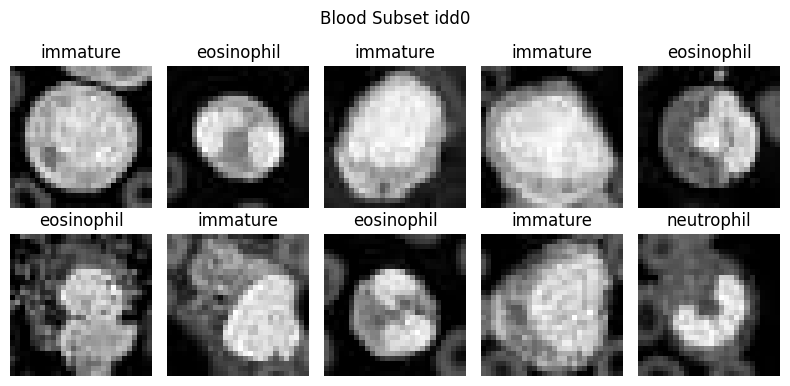

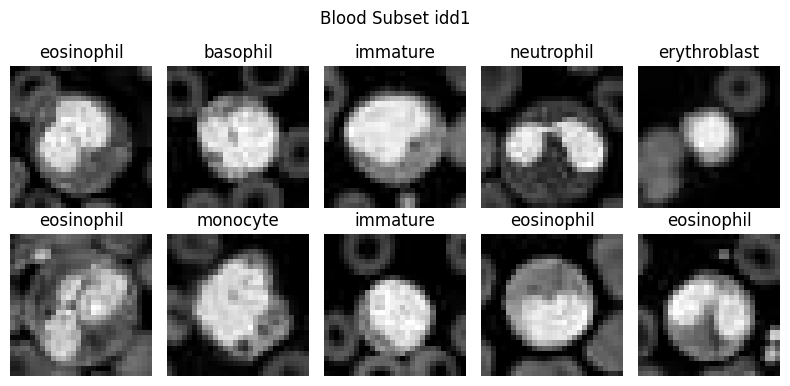

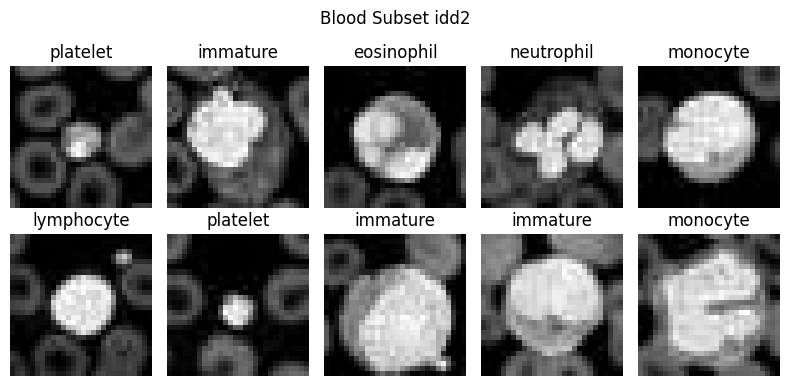

In [73]:
def plot_samples2(data, channel:int, title=None, plot_name="", n_examples =20):
    n_rows = int(n_examples / 5)
    plt.figure(figsize=(8, 2*n_rows))
    if title:
      plt.suptitle(title)

    X, y = data
    class_names = list(train_dataset.info['label'].items())

    for idx in range(n_examples):
        ax = plt.subplot(n_rows, 5, idx + 1)
        name = class_names[y[idx].item()][1].split()[0]
        ax.set_title(name)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap="gray")
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

for i in range(3):
  plot_samples2(next(iter(blood_iid_train[i])), 0, title="Blood Subset idd" + str(i),  n_examples=10)

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


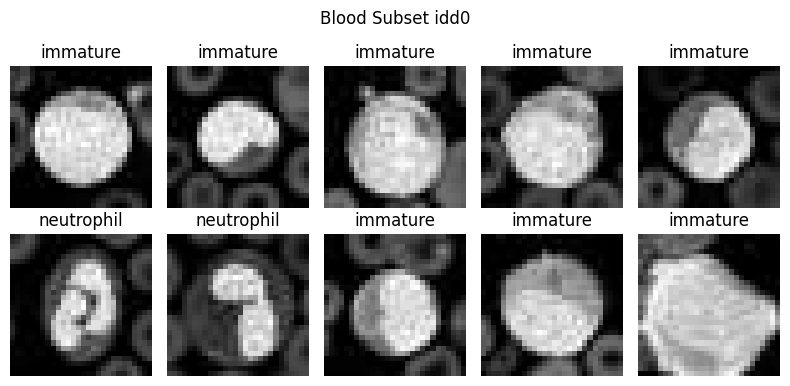

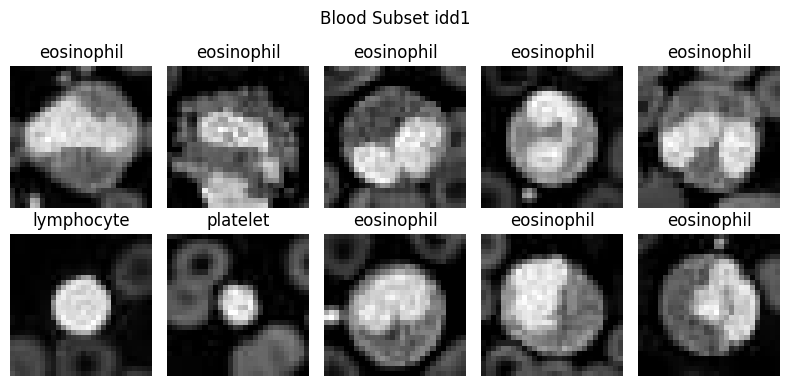

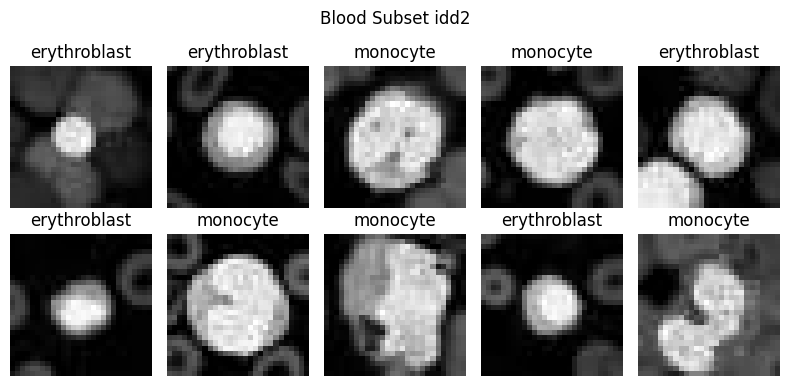

In [100]:
blood_noniid_train, blood_noniid_test = get_BLOOD(type=NON_IID, n_samples_train=200, n_samples_test=100,
                                            n_clients=3, batch_size=25,)

for i in range(3):
  plot_samples2(next(iter(blood_noniid_train[i])), 0, title="Blood Subset idd" + str(i),  n_examples=10)

### Exercice 6 : Use federated learning on medical data

### IID data

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [101]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes: int):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [102]:
nbr_classe = len(train_dataset.info['label'])
nbr_classe

8

In [103]:
custom_model = CustomCNN(nbr_classe)
model, loss_hist, acc_hist = FedProx(custom_model, blood_iid_train,
                                     20, blood_iid_test, epochs=3, lr=0.001)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.123948574066162 Server Test Accuracy: 12.0
====> i: 1 Loss: 1.5749136209487915 Server Test Accuracy: 43.666666666666664
====> i: 2 Loss: 0.8443386554718018 Server Test Accuracy: 64.0
====> i: 3 Loss: 0.6746346155802408 Server Test Accuracy: 68.0
====> i: 4 Loss: 0.5735483566919962 Server Test Accuracy: 70.0
====> i: 5 Loss: 0.5234670639038086 Server Test Accuracy: 74.0
====> i: 6 Loss: 0.4403585294882456 Server Test Accuracy: 78.66666666666666
====> i: 7 Loss: 0.400931308666865 Server Test Accuracy: 79.33333333333333
====> i: 8 Loss: 0.3756978511810303 Server Test Accuracy: 77.33333333333333
====> i: 9 Loss: 0.34836416443188983 Server Test Accuracy: 75.33333333333333
====> i: 10 Loss: 0.32515506943066913 Server Test Accuracy: 81.66666666666666
====> i: 11 Loss: 0.30131645003954566 Server Test Accuracy: 79.33333333333333
====> i: 12 Loss: 0.26397308707237244 Server Test Accuracy: 79.0
====>

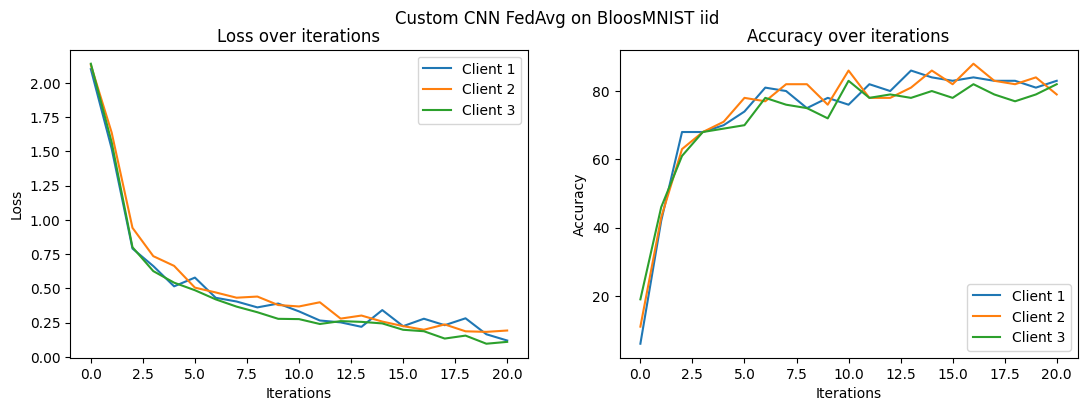

In [104]:
plot_acc_loss("Custom CNN FedAvg on BloosMNIST iid", loss_hist, acc_hist)

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

In [105]:
custom_model = CustomCNN(nbr_classe)
model, loss_hist, acc_hist = FedProx(custom_model, blood_iid_train,
                                     20, blood_iid_test, epochs=3, lr=0.001, mu=0.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.1103340784708657 Server Test Accuracy: 15.666666666666664
====> i: 1 Loss: 1.6382617553075154 Server Test Accuracy: 44.666666666666664
====> i: 2 Loss: 0.8549092809359232 Server Test Accuracy: 68.33333333333333
====> i: 3 Loss: 0.7194324930508931 Server Test Accuracy: 70.66666666666666
====> i: 4 Loss: 0.5505091150601704 Server Test Accuracy: 76.33333333333333
====> i: 5 Loss: 0.492551972468694 Server Test Accuracy: 73.33333333333333
====> i: 6 Loss: 0.42249057690302527 Server Test Accuracy: 77.33333333333333
====> i: 7 Loss: 0.44286178549130756 Server Test Accuracy: 76.66666666666666
====> i: 8 Loss: 0.33913760383923847 Server Test Accuracy: 78.33333333333333
====> i: 9 Loss: 0.35181062420209247 Server Test Accuracy: 77.66666666666666
====> i: 10 Loss: 0.286836306254069 Server Test Accuracy: 80.33333333333333
====> i: 11 Loss: 0.25948629776636756 Server Test Accuracy: 76.0
====> i: 12 Los

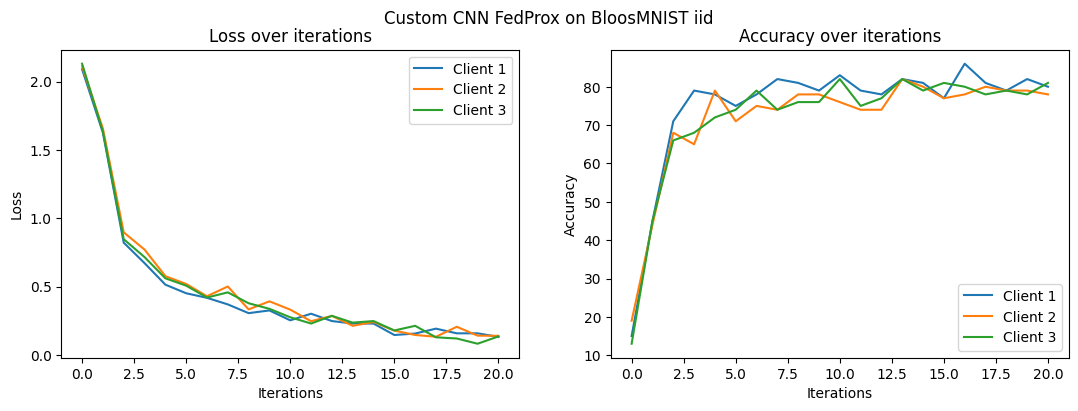

In [106]:
plot_acc_loss("Custom CNN FedProx on BloosMNIST iid", loss_hist, acc_hist)

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

In [109]:
custom_model = CustomCNN(nbr_classe)
model, loss_hist, acc_hist = FedProx(custom_model, blood_noniid_train,
                                     20, blood_noniid_test, epochs=3, lr=0.001, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.0903969208399453 Server Test Accuracy: 13.0
====> i: 1 Loss: 1.8240517377853394 Server Test Accuracy: 30.666666666666664
====> i: 2 Loss: 1.6921691099802652 Server Test Accuracy: 35.0
====> i: 3 Loss: 1.434354027112325 Server Test Accuracy: 39.666666666666664
====> i: 4 Loss: 1.4650766054789224 Server Test Accuracy: 43.666666666666664
====> i: 5 Loss: 1.3885152141253152 Server Test Accuracy: 46.33333333333333
====> i: 6 Loss: 1.3726775646209717 Server Test Accuracy: 50.33333333333333
====> i: 7 Loss: 1.1969513495763142 Server Test Accuracy: 55.66666666666666
====> i: 8 Loss: 1.1638948917388914 Server Test Accuracy: 50.0
====> i: 9 Loss: 1.2353910406430562 Server Test Accuracy: 55.0
====> i: 10 Loss: 1.1626503467559814 Server Test Accuracy: 53.0
====> i: 11 Loss: 1.3630460302035012 Server Test Accuracy: 52.0
====> i: 12 Loss: 1.3529125452041626 Server Test Accuracy: 48.666666666666664
====>

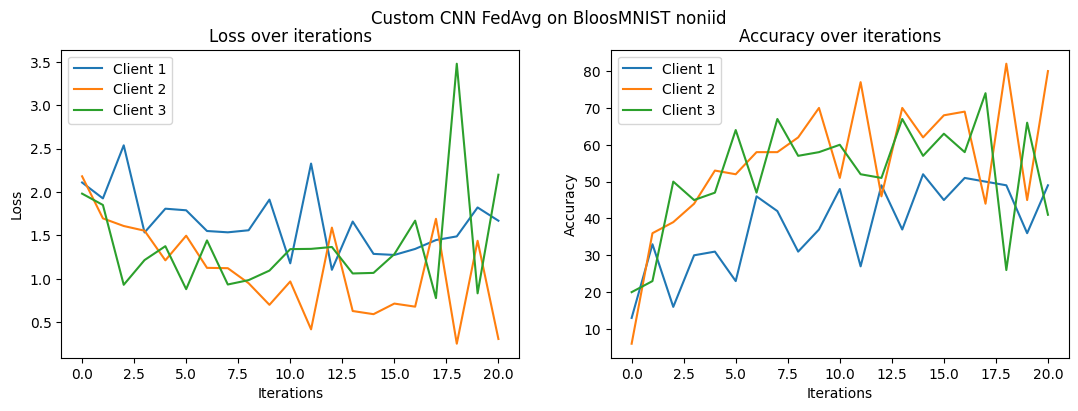

In [110]:
plot_acc_loss("Custom CNN FedAvg on BloosMNIST noniid", loss_hist, acc_hist)

In [113]:
custom_model = CustomCNN(nbr_classe)
model, loss_hist, acc_hist = FedProx(custom_model, blood_noniid_train,
                                     20, blood_noniid_test, epochs=3, lr=0.005, mu=0.9)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.1867958704630532 Server Test Accuracy: 11.666666666666666
====> i: 1 Loss: 1.8081845442454019 Server Test Accuracy: 31.999999999999996
====> i: 2 Loss: 1.8019394477208455 Server Test Accuracy: 29.999999999999996
====> i: 3 Loss: 1.6455530325571694 Server Test Accuracy: 34.666666666666664
====> i: 4 Loss: 1.5306553045908609 Server Test Accuracy: 39.0
====> i: 5 Loss: 1.5847038626670837 Server Test Accuracy: 39.0
====> i: 6 Loss: 1.6431390047073364 Server Test Accuracy: 46.99999999999999
====> i: 7 Loss: 1.5828126668930054 Server Test Accuracy: 44.0
====> i: 8 Loss: 1.5031127134958902 Server Test Accuracy: 48.66666666666666
====> i: 9 Loss: 1.7600418329238892 Server Test Accuracy: 45.666666666666664
====> i: 10 Loss: 1.6768535474936166 Server Test Accuracy: 49.0
====> i: 11 Loss: 1.694965879122416 Server Test Accuracy: 47.0
====> i: 12 Loss: 1.5644927819569905 Server Test Accuracy: 48.666666

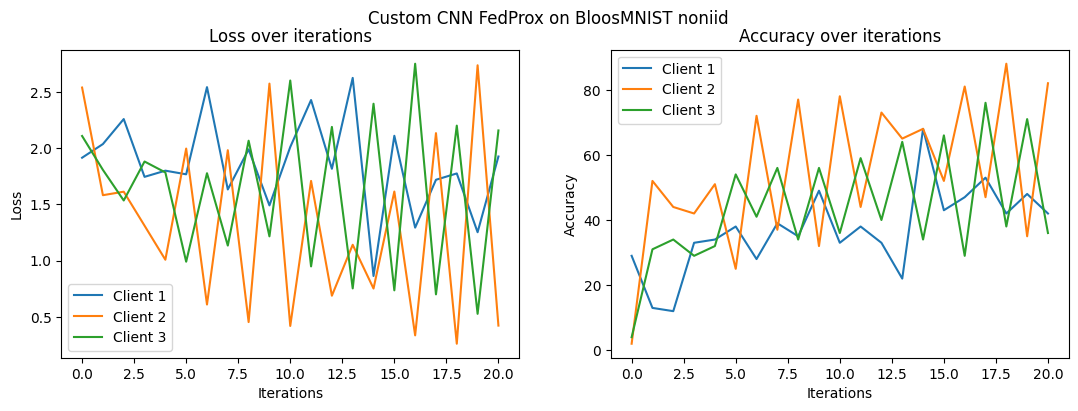

In [114]:
plot_acc_loss("Custom CNN FedProx on BloosMNIST noniid", loss_hist, acc_hist)

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf